In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
!pip install transformers

     |████████████████████████████████| 501kB 2.7MB/s 
     |████████████████████████████████| 870kB 9.6MB/s 
     |████████████████████████████████| 3.7MB 19.0MB/s 
     |████████████████████████████████| 1.0MB 38.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=c2a3970185f00aa124f7bee64d9bda8d858d774f912db65881fefe8cf953b4bc
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [6]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/MinorProject/iben_train.csv")
df=df.drop(columns=['ID','Sub-task A'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 3,826



,Text,Sub-task B
2735,Derozio college ta rajarhat e Laketown e na,NGEN
1650,কোথায এটা বলো না,NGEN
2636,বাঁদরকে মাথায় তুল্লে যা হয় আরকি 😂😂\nওর জন্য স্...,GEN
2358,Tomar channel a notun dada,NGEN
2690,Ranu Di atta khan ki,NGEN
3262,Bah bah bah.. 3k dislike???? Eto sundor ekta v...,NGEN
2956,Apni chup korun...valo sujog sobai pai Na..r a...,NGEN
1868,Aita kothay dada?,NGEN
2363,রানু দি কে ফের স্টেশনে পাঠিয়ে দিন।,NGEN
420,Chup bokachoda faltu kotha bondho kar.,GEN


In [7]:
df['Sub-task B'] = df['Sub-task B'].map({'GEN': 0, 'NGEN':1})
df.head()

,Text,Sub-task B
0,Dada taratari,1
1,Tumi korbe Amar sathe,1
2,Ar ta chara a sob bessha peter cheleder okhan ...,0
3,কাকের শরীরে ময়ুরের পাখা লাগিয়েছে,1
4,পতিতাদের চরিত্র রাজনৈতিক নেতাদের থেকে হাজার গু...,1


In [0]:
df=df.rename(columns={"Sub-task B":"label"})

In [0]:
sentences = df.Text.values
labels = df.label.values

In [10]:
sentences

array(['Dada taratari', 'Tumi korbe Amar sathe',
       'Ar ta chara a sob bessha peter cheleder okhan diye dhukano dorkar',
       ..., 'abar 4 no.platforme jabe bati hate niye', 'Ghinna mondol',
       'লতা মঙ্গেশকার ও আশা ভোষলে কেও হার মানিয়েছে'], dtype=object)

In [11]:
labels

array([1, 1, 0, ..., 1, 1, 1])

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent, 
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


In [14]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  574


In [15]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 100
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Using TensorFlow backend.


In [0]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    108.    Elapsed: 0:00:13.
  Batch    80  of    108.    Elapsed: 0:00:27.

  Average training loss: 0.47
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    108.    Elapsed: 0:00:13.
  Batch    80  of    108.    Elapsed: 0:00:26.

  Average training loss: 0.37
  Training epcoh took: 0:00:35

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    108.    Elapsed: 0:00:13.
  Batch    80  of    108.    Elapsed: 0:00:26.

  Average training loss: 0.29
  Training epcoh took: 0:00:35

Running Validation...
  Accuracy: 0.87
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    108.    Elapsed: 0:00:13.
  Batch    80  of    108.    Elapsed: 0:00:26.

  Average training loss: 0.24
  Training epcoh took: 0:00:35

Ru

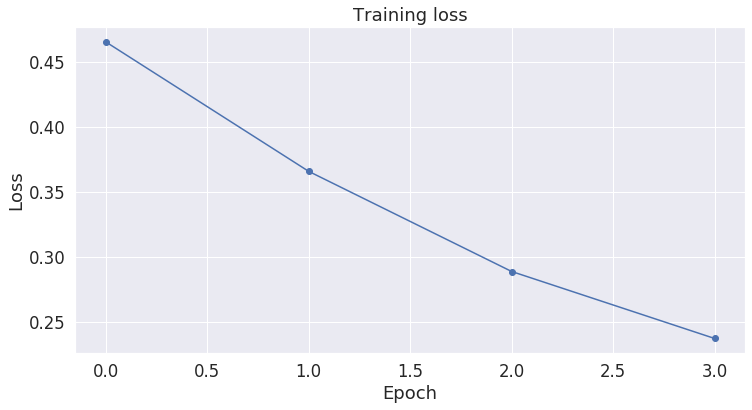

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [28]:
df1 = pd.read_csv("/content/drive/My Drive/MinorProject/iben_dev.csv")
df1=df1.drop(columns=['ID','Sub-task A'])
print('Number of test sentences: {:,}\n'.format(df1.shape[0]))
df1['Sub-task B'] = df1['Sub-task B'].map({'GEN': 0, 'NGEN':1})
df1

Number of test sentences: 957



,Text,Sub-task B
0,Ek dom sothik kotha bolecho jhekane theka uthe...,1
1,ফালতু মেয়ে,1
2,DARUN AKDOM THIK,1
3,Sala ranu magi,0
4,থামবেল ঠিককোরে বানা,1
...,...,...
952,Vai ei public k bole kichu hbe na. Vikhari k v...,1
953,Dada eder j Tumi galagali dile aktu vebe dekho...,1
954,এই জায়গাটা কোথায়,1
955,Fata fati👍👍👍,1


In [0]:
df1=df1.rename(columns={"Sub-task B":"label"})
sentences = df1.Text.values
labels = df1.label.values


In [30]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                     
                        add_special_tokens = True, 
                                           )
    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (878 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


In [31]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits) 
  true_labels.append(label_ids)


Predicting labels for 957 test sentences...


In [32]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 3114 of 3826 (81.39%)


In [0]:
from sklearn.metrics import classification_report
clf_set = []
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  clf = classification_report(true_labels[i], pred_labels_i)                
  clf_set.append(clf)

In [34]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
clf= classification_report(flat_true_labels, flat_predictions)
print(clf)

              precision    recall  f1-score   support

           0       0.79      0.52      0.63       191
           1       0.89      0.97      0.93       766

    accuracy                           0.88       957
   macro avg       0.84      0.74      0.78       957
weighted avg       0.87      0.88      0.87       957

